#### Notebook setup

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import warnings
import os, sys
from types import SimpleNamespace

_lib_path, _abs_path = None, os.path.abspath('.')
if os.path.dirname(_abs_path) == 'multirotor':
    _lib_path = os.path.abspath(os.path.join(_abs_path, '..'))
elif os.path.isdir('multirotor'):
    _lib_path = _abs_path
if _lib_path is not None and _lib_path not in sys.path:
    sys.path.append(_lib_path)

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange
try:
    import pygazebo
    from pygazebo.msg.v11.world_control_pb2 import WorldControl
    from gym_env import RemoteOctorotor
    from gazebo_comms import GazeboCommms
    from msgs.messages_pb2 import Action, State
except ImportError:
    warnings.warn('Could not import pygazebo. Remote communication with gazebo back-end will not work.')

from multirotor.helpers import control_allocation_matrix
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams
from multirotor.control import PosController, AttController, AltController, Controller
from multirotor.simulation import Multirotor, Propeller, Motor, Battery
from multirotor.visualize import VehicleDrawing
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, angular_to_euler_rate
from multirotor.env import DynamicsMultirotorEnv as LocalOctorotor
from multirotor.trajectories import Trajectory

In [ ]:
# Plotting parameters
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Parameters

In [ ]:
# Tarot T18 params
mp = MotorParams(
    moment_of_inertia=5e-5,
    resistance=0.27,
    k_emf=0.0265
)
pp = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05,
    k_drag=1.8503e-06,
    motor=mp
)
vp = VehicleParams(
    propellers=[pp] * 8,
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi,
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(0.001, 9.81)

### Multirotor

#### Motor

In [ ]:
motor = Motor(mp, sp)

In [ ]:
for signal in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    speeds = []
    motor.reset()
    for i in range(200):
        speeds.append(motor.step(signal))
    plt.plot(speeds, label='%dV' % signal)
plt.legend(ncol=2)
plt.ylabel('Speed rad/s')
plt.xlabel('Time /ms')

#### Propeller

In [ ]:
prop = Propeller(pp, sp)
speeds = np.linspace(0, 600, num=100)
thrusts = []
for s in speeds: thrusts.append(prop.thrust(s))
plt.plot(speeds, thrusts, label='Thrust /N')
plt.xlabel('Speed rad/s')
plt.ylabel('Thrust /N')

#### Multirotor

In [ ]:
m = Multirotor(vp, sp)
m.reset()

In [ ]:
action = m.allocate_control(m.weight, np.asarray([0, 1e-1, 0]))
for i in range(500): m.step_speeds(action)
print(m.orientation * 180 / np.pi)

In [ ]:
m.reset()
ctrl = Controller(
    PosController(0.1, 0.0, 0., 1., dt=1e-3, vehicle=m),
    AttController(np.asarray([10., 10., 0]), 0, 0., 1., dt=1e-3, vehicle=m),
    AltController(10,0,0,1, dt=1e-3, vehicle=m)
)


positions = []
errs = []
alloc_th = []
alloc_to = []
orientations = []
actions = []

targets = [[0,0,2], [0,10,2], [10,10,2], [10,0,2], [0,0,0]]
for i in trange(len(targets), leave=False):
    ref = np.asarray([*targets[i], 0.])
    # Get prescribed dynamics for system
    dynamics = ctrl.step(ref)
    thrust, torques = dynamics[0], dynamics[1:]
    errs.append(ctrl.ctrl_p.err)
    alloc_th.append(thrust)
    alloc_to.append(torques)
    # Convert dynamics into motor RPMs
    action = m.allocate_control(thrust, torques)
    actions.append(action)
    m.step_speeds(action)
    positions.append(m.position)
    orientations.append(m.orientation)
    if i >= 60000: break

positions = np.asarray(positions)
errs = np.asarray(errs)
alloc_th = np.asarray(alloc_th)
alloc_to = np.asarray(alloc_to)
orientations = np.asarray(orientations)
actions = np.asarray(actions)

In [ ]:
plt.figure(figsize=(14,9))
plt.subplot(1,2,1)
for p,l, c in zip(positions.T, 'xyz', 'rgb'):
    plt.plot(p, label=l, c=c)
lines = plt.gca().lines
plt.twinx()
for p,l,c in zip(orientations.T, ('roll', 'pitch', 'yaw'), 'cmy'):
    plt.plot(p * 180 / np.pi, label=l, ls=':', c=c)
plt.legend(handles=plt.gca().lines+lines)

plt.subplot(1,2,2)
l = plt.plot(alloc_th, label='Ctrl Thrust')
plt.twinx()
for i, c, a in zip(range(3), 'rgb', 'xyz'):
    plt.plot(alloc_to[:,i], label='Ctrl Torque %s' % a, c=c)
plt.legend(handles=plt.gca().lines + l)

### Message Passing

In [ ]:
gc = GazeboCommms()
# List all topics gazebo is publishing to:
gc.manager.publications()

In [ ]:
# Create a protobuf message
a = Action()
a.type = a.DYNAMICS
a.values.extend([0., 0., 0., 0., 0., 0.])
# We can send the message over TCP. However, we will not get the state vector
# back in response, because the custom environment plugin is only listening on UDP.
# gc.send_TCP(a, '/tarot/action')

In [ ]:
# Reset
a = Action()
a.reset = True
a.state.position.extend([1,0,1])
a.state.velocity.extend([3,0,0])
a.state.orientation.extend([0,0,0])
a.state.angular_rate.extend([0,0,0])
a
# gc.send_TCP(a, '/tarot/action')

In [ ]:
# Send action over UDP. The gazebo plugin will respond back with the state vector when getting a UDP message
gc.send_UDP(a)

In [ ]:
# Create and send a default gazebo message. These packets are directly handled
# by gazebo, and not the custom plugin
c = WorldControl()
c.reset.all = True
c.multi_step = 100
gc.send_TCP(c, '/gazebo/test/world_control')

### AP Simulation

In [ ]:
import socket
import time
import json
import struct
from multirotor.coords import direction_cosine_matrix, body_to_inertial

In [ ]:
def wind(t, m):
    w_inertial = np.asarray([5 * np.sin(t * 2 * np.pi / 4000), 0, 0])
    dcm = direction_cosine_matrix(*m.orientation)
    return inertial_to_body(w_inertial, dcm)

In [ ]:
def changeToJSONString(curr_time, state, accel):
    phys_time = curr_time
    pos = state[0:3].tolist()
    velo = state[3:6]
    euler = state[6:9].tolist()
    gyro = state[9:12].tolist()
    accel = accel.tolist()

    pos[2] = -1*pos[2]
    pos[0], pos[1] = pos[1], pos[0]

    dcm = direction_cosine_matrix(*euler)
    v_inertial = body_to_inertial(velo, dcm).tolist()
    v_inertial[2] = -1*v_inertial[2]
    v_inertial[0], v_inertial[1] = v_inertial[1], v_inertial[0]

    gyro[0], gyro[1] = gyro[1], gyro[0]
    gyro[2] = -1*gyro[2]
    euler[0], euler[1] = euler[1], euler[0]
    euler[2] = -1*euler[2]

    # Build JSON format
    IMU_fmt = {
        "gyro" : gyro,
        "accel_body" : accel
    }
    JSON_fmt = {
        "timestamp" : phys_time,
        "imu" : IMU_fmt,
        "position" : pos,
        "attitude" : euler,
        "velocity" : v_inertial
    }

    JSON_string = "\n" + json.dumps(JSON_fmt,separators=(',', ':')) + "\n"

    return JSON_string


In [59]:
def ap_sim(env, sock, steps=600000, disturbance=None):
    command_logger = {}
    state_logger = {}
    
    disturb_force, disturb_torque = 0., 0

    curr_time = 0  # Get the current time in seconds
    RATE_HZ = 400 #should be 400
    TIME_STEP = 1/RATE_HZ
    last_frame = -1
    frame_count = 0
    frame_time = time.time()
    print_frame_count = 500

    state = np.zeros(12)
    
    try:
        for i in range(0, steps):
            try:   
                data, addr = sock.recvfrom(100)
                parse_format = 'HHI16H'
                magic = 18458
                if len(data) != struct.calcsize(parse_format):
                    print("got packet of len %u, expected %u" % (len(data), struct.calcsize(parse_format)))
                    continue
                unpacked_data = struct.unpack(parse_format, data)
                if magic != unpacked_data[0]:
                    print("Incorrect protocol magic %u should be %u" % (unpacked_data[0], magic))
                    continue

                frame_rate = unpacked_data[1]
                frame_count = unpacked_data[2]
                pwm = np.array(unpacked_data[3:11])

                string_action = " ".join(str(element) for element in pwm.tolist())

                if frame_count < last_frame:
                    print('Reset controller')
                elif frame_count == last_frame:
                    # print('Duplicate frame')
                    continue
                if frame_count != last_frame + 1 and last_frame != 0:
                    print("Missed %u frames" % (frame_count - last_frame))
                    continue
                last_frame = frame_count
                
                curr_time += TIME_STEP

                action = (pwm-1000)*0.575

                f, t = m.get_forces_torques(action, state)
                state, *_ = env.step(np.asarray([*f, *t]))

                # These functions don't work for some reason??
                # accel = env.vehicle.dxdt_dynamics(0, state, [*f, *t])[3:6]
                # accel = env.vehicle._dxdt[3:6]
                accel = np.array([0, 0, 0])
                accel[2] = -9.8
                if disturbance is not None:
                    accel[2] += disturb_force[2] #change accel z frame to body
                JSON_string = changeToJSONString(curr_time, state, accel)

                sock.sendto(bytes(JSON_string,"ascii"), addr)
                
                if action[0] != 0:
                    command_logger[i] = action.tolist()
                    state_logger[i] = state.tolist()

            except json.JSONDecodeError:
                print("Invalid JSON data received")
            except socket.timeout:
                continue
            except KeyboardInterrupt:
                sock.close()
            except Exception as e:
                if not isinstance(e, OSError):
                    raise e
                sock.close()
                break
    finally:
        sock.close()
        
    return command_logger, state_logger


In [60]:

UDP_IP = "127.0.0.1"  # Listen on all available interfaces
UDP_PORT = 9002

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP, UDP_PORT))
sock.settimeout(0.1)  # Set a timeout value of 1 second on the socket object

m = Multirotor(vp, sp)
m.reset()
env = RemoteOctorotor(vehicle=m)
env.reset()
action_log, state_log = ap_sim(env, sock, steps=600000, disturbance=None)

sock.close()

Exception in callback Manager.handle_normal_read(<Future finis...onnectError()>)
handle: <Handle Manager.handle_normal_read(<Future finis...onnectError()>)>
Traceback (most recent call last):
  File "/home/zhanga/miniconda3/envs/gazebo/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/zhanga/miniconda3/envs/gazebo/lib/python3.9/site-packages/pygazebo/pygazebo.py", line 644, in handle_normal_read
    data = future.result()
  File "/home/zhanga/miniconda3/envs/gazebo/lib/python3.9/asyncio/futures.py", line 201, in result
    raise self._exception
  File "/home/zhanga/miniconda3/envs/gazebo/lib/python3.9/site-packages/pygazebo/pygazebo.py", line 363, in handle_read
    data = future.result()
  File "/home/zhanga/miniconda3/envs/gazebo/lib/python3.9/asyncio/futures.py", line 201, in result
    raise self._exception
  File "/home/zhanga/miniconda3/envs/gazebo/lib/python3.9/site-packages/pygazebo/pygazebo.py", line 308, in han

### Logging

In [57]:
def printLogMotor(log, lower=0, upper=700):
    element_data = {}

    first_key = next(iter(log))
    for index in range(len(log[first_key])):
        element_data[index] = [data[index] for data in log.values()]

    plt.figure(figsize=(15, 5))

    # Plot the data for each element
    for index, data in element_data.items():
        # Filter data based on condition (value > 2000)
        filtered_data = [value if value >= lower and value <= upper else None for value in data]
        plt.plot(list(log.keys()), filtered_data, label=f"Motor {index+1}")

    # Set plot labels and title
    plt.xlabel("Frames")
    plt.ylabel("Motor command")
    plt.title("Motor Commands over time")

    # Add legend
    plt.legend(loc='upper left', fontsize='small')

    # Display the plot
    plt.show()

In [54]:
def printStateLog(log):
    num_motors = len(log[next(iter(log))])

    fig, axs = plt.subplots(4, 3, figsize=(15, 15))

    labels = ["x", "y", "z", "vx", "vy", "vz", "roll", "pitch", "yaw", "vroll", "vpitch", "vyaw"]

    # Loop through each motor and plot it in the corresponding subplot
    for motor_index, ax in enumerate(axs.flatten()):
        if motor_index < num_motors:
            # Filter and plot the data for the current motor
            filtered_data = [data[motor_index] for data in log.values()]
            ax.plot(list(log.keys()), filtered_data, label=labels[motor_index])

            # Set plot labels and title
            ax.set_xlabel("Frames")
            ax.set_ylabel(labels[motor_index])
            ax.set_title(f"{labels[motor_index]} over time")

            # Add legend
            ax.legend(loc='upper left', fontsize='small')

    # Adjust layout to avoid overlapping titles and labels
    plt.tight_layout()

    # Display the subplots
    plt.show()

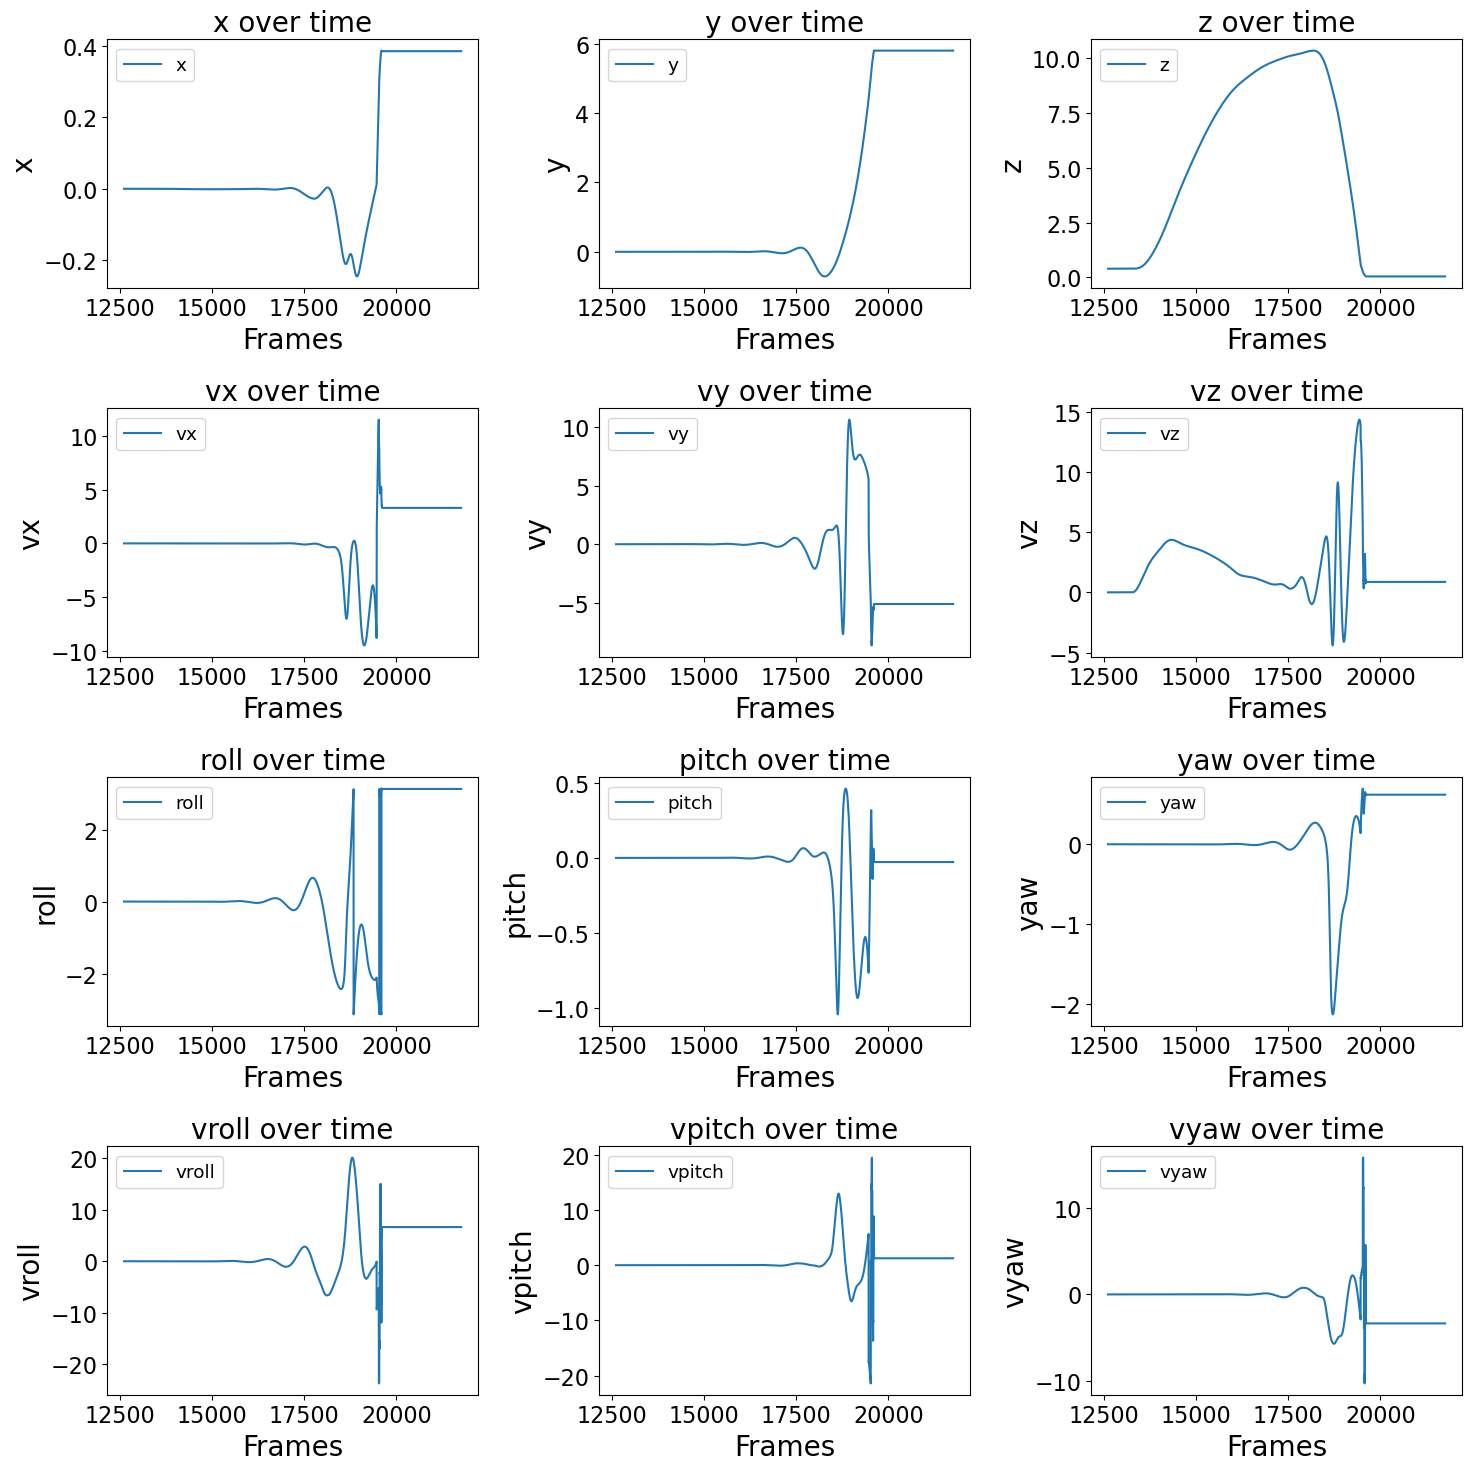

In [55]:
printStateLog(state_log)

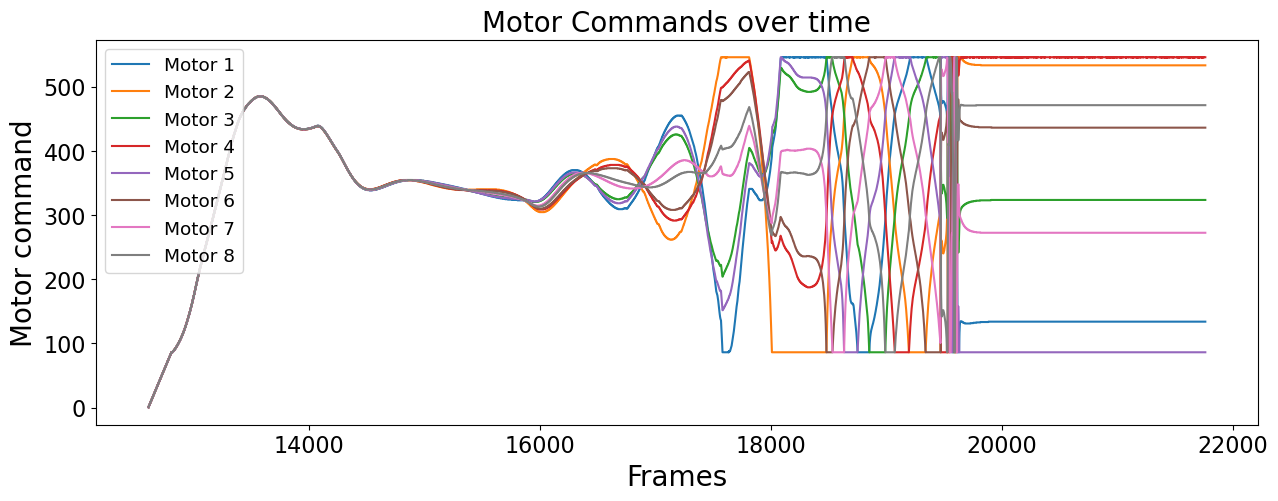

In [58]:
printLogMotor(action_log)

### Simulation

In [ ]:
# def wind(t, m):
#     w_inertial = np.asarray([5 * np.sin(t * 2 * np.pi / 4000), 0, 0])
#     dcm = direction_cosine_matrix(*m.orientation)
#     return inertial_to_body(w_inertial, dcm)[:2]
wind = lambda t, m: [0, 0]

In [ ]:
m = Multirotor(vp, sp)
m.reset()
env = RemoteOctorotor(vehicle=m)
env.reset()
# env = LocalOctorotor(vehicle=m)
# env.vehicle.state[2] = 1.
traj = Trajectory([[0,0,2], [15,0,2], [15,15,2], [0,15,2], [0,0,2]],
                  env.vehicle, proximity=2, resolution=None)

for _ in range(5000):
    state, *_ = env.step(np.asarray([0., 0., vp.mass * sp.g * 1.01, 0., 0., 0.]))
    print(state)

In [ ]:
ctrl = Controller(
    # (Outer) Position controller has low sensitivity
    PosController(0.15, 0.02, 0., 1., dt=1e-3, vehicle=m),
    # (Inner) Attitude controller is more responsive (except for yaw, which we are not controlling)
    AttController(np.asarray([50., 50., 2.]),
                  np.asarray([2., 2., 2.]),
                  np.asarray([0., 0., 0.]), 1., dt=1e-3, vehicle=m),
    # Altitude controller is more responsive as well
    AltController(50, 2, 0, 1, dt=1e-3, vehicle=m)
)
      
targets = []
actions = []
speeds = []
positions = []
velocities = []
orientations = []
errs = SimpleNamespace()
errs.pos = SimpleNamespace()
errs.pos.p, errs.pos.i, errs.pos.d = [], [], []
errs.att = SimpleNamespace()
errs.att.p, errs.att.i, errs.att.d = [], [], []
alloc_errs = []
alloc_th = []
alloc_to = []
thrusts = []

for i, pos in enumerate(traj):
    if i==60000: break
    # Generate reference for controller
    ref = np.asarray([*pos, 0.])
    # Get prescribed dynamics for system as thrust and torques
    dynamics = ctrl.step(ref)
    thrust, torques = dynamics[0], dynamics[1:]
    # Allocate control: Convert dynamics into motor rad/s
    action = m.allocate_control(thrust, torques)
    # Add any faults/restrictions to motor dynamics
    action = np.clip(action, a_min=0, a_max=400)
    # if i > 30000: action[3] = min(action[3], 300)
    # Get resultant forces/torques given propeller states
    f, t = m.get_forces_torques(action, state)
    # Add environmental disturbances
    f[:2] += wind(i, env.vehicle)
    # Send dynamics to environment
    state, *_ = env.step(np.asarray([*f, *t]))
    
    targets.append(pos)
    for (c, e) in zip((ctrl.ctrl_p, ctrl.ctrl_a), (errs.pos, errs.att)):
        e.p.append(c.err_p)
        e.i.append(c.err_i)
        e.d.append(c.err_d)
    alloc_th.append(thrust)
    alloc_to.append(torques)
    alloc_errs.append(np.asarray([thrust, *torques]) - m.alloc @ action**2)
    actions.append(action)
    # speeds.append([motor.rpm for motor in m.propellers])
    positions.append(state[:3])
    velocities.append(state[3:6])
    orientations.append(state[6:9])

    if np.any(np.abs(m.orientation[:2]) > np.pi/6): break

targets = np.asarray(targets)
positions = np.asarray(positions)
velocities = np.asarray(velocities)
speeds = np.asarray(speeds)
orientations = np.asarray(orientations) * 180 / np.pi
for e in (errs.pos, errs.att):
    e.p = np.asarray(e.p)
    e.i = np.asarray(e.i)
    e.d = np.asarray(e.d)
alloc_errs = np.asarray(alloc_errs)
alloc_th = np.asarray(alloc_th)
alloc_to = np.asarray(alloc_to)
actions = np.asarray(actions)

In [ ]:
%matplotlib inline
plt.figure(figsize=(21,10.5))
plot_grid = (3,3)
plt.subplot(*plot_grid,1)

plt.plot(positions[:, 0], label='x', c='r')
plt.plot(targets[:len(positions), 0], c='r', ls=':')
plt.plot(positions[:, 1], label='y', c='g')
plt.plot(targets[:len(positions), 1], c='g', ls=':')
plt.plot(positions[:, 2], label='z', c='b')
lines = plt.gca().lines[::2]
plt.ylabel('Position /m')
plt.twinx()
plt.plot(orientations[:, 0], label='roll', c='c', ls=':')
plt.plot(orientations[:, 1], label='pitch', c='m', ls=':')
plt.plot(orientations[:, 2], label='yaw', c='y', ls=':')
plt.ylabel('Orientation /deg')
plt.legend(handles=plt.gca().lines + lines, ncol=2)
plt.title('Position and Orientation')

plt.subplot(*plot_grid,2)
for i in range(actions.shape[1]):
    l, = plt.plot(actions[:,i], label='prop %d' % i)
#     plt.plot(speeds[:,i], c=l.get_c())
lines = plt.gca().lines
plt.legend(handles=lines, ncol=2)
plt.title('Motor speeds /RPM')


plt.subplot(*plot_grid,3)
v_world = np.zeros_like(velocities)
for i, (v, o) in enumerate(zip(velocities, orientations)):
    dcm = direction_cosine_matrix(*o)
    v_world[i] = body_to_inertial(v, dcm)
for i, c, a in zip(range(3), 'rgb', 'xyz'):
    plt.plot(v_world[:,i], label='Velocity %s' % a, c=c)
#     plt.plot(velocities[:,i], label='Velocity %s' % a, c=c)
plt.legend()
plt.title('Velocities')

plt.subplot(*plot_grid,4)
plt.title('Controller allocated dynamics')
l = plt.plot(alloc_th, label='Ctrl Thrust')
plt.ylabel('Force /N')
plt.twinx()
for i, c, a in zip(range(3), 'rgb', 'xyz'):
    plt.plot(alloc_to[:,i], label='Ctrl Torque %s' % a, c=c)
plt.ylabel('Torque /Nm')
plt.legend(handles=plt.gca().lines + l, ncol=2)

plt.subplot(*plot_grid,5)
lines = plt.plot(alloc_errs[:, 0], label='Thrust err', c='b')
plt.ylabel('Thrust /N')
plt.twinx()
plt.plot(alloc_errs[:, 1], label='Torque x err', ls=':')
plt.plot(alloc_errs[:, 2], label='Torque y err', ls=':')
plt.plot(alloc_errs[:, 3], label='Torque z err', ls=':')
plt.legend(handles = plt.gca().lines + lines, ncol=2)
plt.ylabel('Torque /Nm')
plt.title('Allocation Errors')

plt.subplot(*plot_grid,6)
plt.plot(targets[:len(positions),0], targets[:len(positions),1], label='Prescribed traj')
plt.plot(positions[:,0], positions[:,1], label='Actual traj')
plt.gca().set_aspect('equal', 'box')
plt.title('XY positions /m')
plt.legend()

plt.tight_layout()

In [ ]:
%matplotlib inline
lines = []
plt.figure(figsize=(21,24))
plt.subplot(6,1,1)
plt.plot(errs.pos.p[:,0], label='Pos-x P', c='r', ls='-')
plt.plot(errs.pos.p[:,1], label='Pos-y P', c='g', ls='-')
lines += plt.gca().lines
plt.title('Position P errors')
plt.subplot(6,1, 2)
plt.plot(errs.pos.i[:, 0], label='Pos-x I', c='r', ls=':')
plt.plot(errs.pos.i[:, 1], label='Pos-y I', c='g', ls=':')
lines += plt.gca().lines
plt.title('Position I errors')
plt.subplot(6,1, 3)
plt.plot(errs.pos.d[:, 0], label='Pos-x D', c='r', ls='-.')
plt.plot(errs.pos.d[:, 1], label='Pos-y D', c='g', ls='-.')
lines += plt.gca().lines
plt.legend(handles=lines)
plt.title('Position D errors')
lines = []
plt.subplot(6,1,4)
plt.plot(errs.att.p[:,0], label='Att-x P', c='r', ls='-')
plt.plot(errs.att.p[:,1], label='Att-y P', c='g', ls='-')
lines += plt.gca().lines
plt.title('Position P errors')
plt.subplot(6,1, 5)
plt.plot(errs.att.i[:, 0], label='Att-x I', c='r', ls=':')
plt.plot(errs.att.i[:, 1], label='Att-y I', c='g', ls=':')
lines += plt.gca().lines
plt.title('Position I errors')
plt.subplot(6,1, 6)
plt.plot(errs.att.d[:, 0], label='Att-x D', c='r', ls='-.')
plt.plot(errs.att.d[:, 1], label='Att-y D', c='g', ls='-.')
lines += plt.gca().lines
plt.legend(handles=lines)
plt.title('Position D errors')

In [ ]:
%matplotlib notebook
fig = plt.figure()
xlim = ylim = zlim = (np.min(positions), np.max(positions))
ax = fig.add_subplot(projection='3d', xlim=xlim, ylim=ylim, zlim=zlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(positions[:,0], positions[:,1], positions[:,2])

In [ ]:
%matplotlib inline
from scipy.integrate import cumulative_trapezoid
plt.plot(cumulative_trapezoid(v_world[:, 0], dx=1e-3, initial=0.))
plt.plot(positions[:, 0], ls=':', c='r')

### Comparison

In [ ]:
m = Multirotor(vp, sp)
m.reset()
env = RemoteOctorotor(vehicle=m)
traj = Trajectory([[0,0,2], [0,5,2], [5,5,2], [5,0,2], [0,0,2]],
                  env.vehicle, proximity=0.2, resolution=0.25)

env.reset()

for _ in range(2000):
    state, *_ = env.step(np.asarray([0., 0., vp.mass * sp.g * 1.001, 0., 0., 0.]))

In [ ]:
# def wind(t, m):
#     w_inertial = np.asarray([5 * np.sin(t * 2 * np.pi / 4000), 0, 0])
#     dcm = direction_cosine_matrix(*m.orientation)
#     return inertial_to_body(w_inertial, dcm)[:2]
wind = lambda t, m: [0, 0]

In [ ]:
# m.propellers[2].params.k_thrust = 4.9e-5
# m.propellers[3].params.k_thrust = 4.9e-5
# env.vehicle.propellers[2].params.k_thrust = pp.k_thrust * 0.95

ctrl = Controller(
    PosController(0.5, 0.0, 0.1, 1., m),
    AttController(np.asarray([50., 50., 0.1]), 0, np.asarray([10., 10., 0.1]), 1., m),
    AltController(144,0,24,1,m)
)

ctargets = []
cactions = []
cspeeds = []
cpositions = []
cvelocities = []
corientations = []
cerrs = []
calloc_errs = []
calloc_th = []
calloc_to = []
cthrusts = []

for i, pos in enumerate(traj):
    if i==100000: break
    # Get prescribed dynamics for system
    ref = np.asarray([*pos, 0.])
    dynamics = ctrl.step(ref)
    thrust, torques = dynamics[0], dynamics[1:]
    # Convert dynamics into motor rad/s
    action = m.allocate_control(thrust, torques)
    action = np.clip(action, a_min=0, a_max=400)
    # if i > 30000: action[3] = min(action[3], 300)
    # Get resultant forces/torques given propeller states
    f, t = m.get_forces_torques(action, state)
    # Add disturbances
    f[:2] += wind(i, env.vehicle)
    # Convert RPM to voltage and apply to simulation
    # state, _, done, _ = env.step(normalize_voltage(rpm_to_voltage(action)))
    state, *_ = env.step(np.asarray([*f, *t]))
    
    ctargets.append(pos)
    cerrs.append(ctrl.ctrl_p.err)
    calloc_th.append(thrust)
    calloc_to.append(torques)
    calloc_errs.append(np.asarray([thrust, *torques]) - m.alloc @ action**2)
    cactions.append(action)
#     speeds.append([motor.rpm for motor in m.propellers])
    cpositions.append(state[:3])
    cvelocities.append(state[3:6])
    corientations.append(state[6:9])

    if np.any(np.abs(m.orientation[:2]) > np.pi/6): break

In [ ]:
ctargets = np.asarray(ctargets)
cpositions = np.asarray(cpositions)
cvelocities = np.asarray(cvelocities)
cspeeds = np.asarray(cspeeds)
corientations = np.asarray(corientations) * 180 / np.pi
cerrs = np.asarray(cerrs)
calloc_errs = np.asarray(calloc_errs)
calloc_th = np.asarray(calloc_th)
calloc_to = np.asarray(calloc_to)
cactions = np.asarray(cactions)

#### Plotting

In [ ]:
cpositions = np.asarray(cpositions)
plt.figure(figsize=(6,6))
# plt.plot(targets[:len(positions),0], targets[:len(positions),1], label='Prescribed traj')
plt.plot(cpositions[:40000,0], cpositions[:40000,1], label='Gazebo traj')
plt.plot(positions[:40000,0], positions[:40000,1], label='Python traj', ls=':', lw=4)
plt.gca().set_aspect('equal', 'box')
plt.title('XY positions /m')
plt.grid(which='both')
plt.legend()

plt.gca().add_patch(plt.Rectangle((0,5), 1,1))
plt.gca().add_patch(plt.Rectangle((4.5,4.5), 1,1))
plt.text(1,5.5, "5kg hovering object")
plt.text(2,4, "100kg ground obstacle")

In [ ]:
plt.figure(figsize=(14,10.5))
plot_grid = (3,2)
plt.subplot(*plot_grid,1)

plt.plot(cpositions[:, 0], label='x', c='r')
plt.plot(ctargets[:len(cpositions), 0], c='r', ls=':')
plt.plot(cpositions[:, 1], label='y', c='g')
plt.plot(targets[:len(positions), 1], c='g', ls=':')
plt.plot(cpositions[:, 2], label='z', c='b')
lines = plt.gca().lines[::2]
plt.ylabel('Position /m')
plt.twinx()
plt.plot(corientations[:, 0], label='roll', c='c', ls=':')
plt.plot(corientations[:, 1], label='pitch', c='m', ls=':')
plt.plot(corientations[:, 2], label='yaw', c='y', ls=':')
plt.ylabel('Orientation /deg')
plt.legend(handles=plt.gca().lines + lines, ncol=2)
plt.title('Position and Orientation')

plt.subplot(*plot_grid,2)
for i in range(cactions.shape[1]):
    l, = plt.plot(cactions[:,i], label='prop %d' % i)
#     plt.plot(speeds[:,i], c=l.get_c())
lines = plt.gca().lines
plt.legend(handles=lines, ncol=2)
plt.title('Motor speeds /RPM')

plt.subplot(*plot_grid,3)
v_world = np.zeros_like(velocities)
for i, (v, o) in enumerate(zip(cvelocities, corientations)):
    dcm = direction_cosine_matrix(*o)
    v_world[i] = body_to_inertial(v, dcm)
for i, c, a in zip(range(3), 'rgb', 'xyz'):
#     plt.plot(v_world[:,i], label='Velocity %s' % a, c=c)
    plt.plot(cvelocities[:,i], label='Velocity %s' % a, c=c)
plt.legend()
plt.title('Velocities')

plt.subplot(*plot_grid,4)
plt.title('Controller allocated dynamics')
l = plt.plot(calloc_th, label='Ctrl Thrust')
plt.ylabel('Force /N')
plt.twinx()
for i, c, a in zip(range(3), 'rgb', 'xyz'):
    plt.plot(calloc_to[:,i], label='Ctrl Torque %s' % a, c=c)
plt.ylabel('Torque /Nm')
plt.legend(handles=plt.gca().lines + l, ncol=2)

plt.subplot(*plot_grid,5)
lines = plt.plot(calloc_errs[:, 0], label='Thrust err', c='b')
plt.ylabel('Thrust /N')
plt.twinx()
plt.plot(alloc_errs[:, 1], label='Torque x err', ls=':')
plt.plot(alloc_errs[:, 2], label='Torque y err', ls=':')
plt.plot(alloc_errs[:, 3], label='Torque z err', ls=':')
plt.legend(handles = plt.gca().lines + lines, ncol=2)
plt.ylabel('Torque /Nm')
plt.title('Allocation Errors')

plt.subplot(*plot_grid,6)
plt.plot(targets[:len(cpositions),0], targets[:len(cpositions),1], label='Prescribed traj')
plt.plot(cpositions[:,0], cpositions[:,1], label='Actual traj')
plt.gca().set_aspect('equal', 'box')
plt.title('XY positions /m')
plt.legend()

plt.tight_layout()

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(velocities[:40000,0], c='r', label='x velocity, Python')
plt.plot(cvelocities[:40000,0], c='r', ls=':', lw=2, label='x velocity, Gazebo')
plt.plot(velocities[:40000,1], c='g', label='y velocity, Python')
plt.plot(cvelocities[:40000,1], c='g', ls=':', lw=2, label='y velocity, Gazebo')
plt.grid(which='both')
plt.ylabel('Velocity / m/s')
plt.title('Collision physics')
plt.legend(ncol=1)

### Variations

In [ ]:
from multirotor.helpers import vehicle_params_factory

In [ ]:
vp4 = vehicle_params_factory(4, m_prop=0.125, d_prop=0.25, params=pp, m_body=4)
vp6 = vehicle_params_factory(6, m_prop=0.125, d_prop=0.5, params=pp, m_body=6)
vp8 = vehicle_params_factory(8, m_prop=0.125, d_prop=0.75, params=pp, m_body=8)

positionsx = []
for vpx in [vp4, vp6, vp8]:
    m = Multirotor(vpx, sp)
    m.reset()
    # env = RemoteOctorotor(vehicle=m)
    env = LocalOctorotor(vehicle=m)
    env.vehicle.state[2] = 1.
    traj = Trajectory([[0,0,2], [2.5,5,2], [5,0,2], [0,0,2]],
                      env.vehicle, proximity=0.2, resolution=0.5)

    env.reset()

    for _ in range(2000):
        state, *_ = env.step(np.asarray([0., 0., vpx.mass * sp.g * 1.001, 0., 0., 0.]))
    
    ctrl = Controller(
        PosController(0.5, 0.0, 0.1, 1., m),
        AttController(np.asarray([50., 50., 0.1]), 0, np.asarray([10., 10., 0.1]), 1., m),
        AltController(144,0,24,1,m)
    )

    targets = []
    actions = []
    speeds = []
    positions = []
    velocities = []
    orientations = []
    errs = []
    alloc_errs = []
    alloc_th = []
    alloc_to = []
    thrusts = []

    for i, pos in enumerate(traj):
        if i==60000: break
        # Get prescribed dynamics for system
        ref = np.asarray([*pos, 0.])
        dynamics = ctrl.step(ref)
        thrust, torques = dynamics[0], dynamics[1:]
#         print(torques)
        # Convert dynamics into motor rad/s
        action = m.allocate_control(thrust, torques)
        action = np.clip(action, a_min=0, a_max=400)
        # if i > 30000: action[3] = min(action[3], 300)
        # Get resultant forces/torques given propeller states
        f, t = m.get_forces_torques(action, state)
        # Add disturbances
        f[:2] += np.asarray([2, 2])
        # Convert RPM to voltage and apply to simulation
        # state, _, done, _ = env.step(normalize_voltage(rpm_to_voltage(action)))
        state, *_ = env.step(np.asarray([*f, *t]))

        targets.append(pos)
        errs.append(ctrl.ctrl_p.err)
        alloc_th.append(thrust)
        alloc_to.append(torques)
        alloc_errs.append(np.asarray([thrust, *torques]) - m.alloc @ action**2)
        actions.append(action)
    #     speeds.append([motor.rpm for motor in m.propellers])
        positions.append(state[:3])
        velocities.append(state[3:6])
        orientations.append(state[6:9])

        if np.any(np.abs(m.orientation[:2]) > np.pi/6): break
    positionsx.append(np.asarray(positions))

In [ ]:
plt.figure(figsize=(6,6))
for cpositions, label, ls, lw in zip(
    positionsx,
    ('quad-rotor', 'hexa-rotor', 'octo-rotor'),
    ('-','--',':'),
    (2,3,4)
):
    cpositions = np.asarray(cpositions)
    plt.plot(cpositions[:,0], cpositions[:,1], label=label, ls=ls, lw=lw)
plt.gca().set_aspect('equal', 'box')
plt.title('XY positions /m')
plt.grid(which='both')
plt.legend()